In [165]:
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import numpy.linalg as lin
from itertools import repeat
from collections import defaultdict
%matplotlib inline
np.set_printoptions(precision=2)

In [182]:
#Model parameters
eps = 0.01

In [183]:
#Prepare Graph

G=nx.Graph()
G.add_nodes_from([1,2,3,"Sg"], bipartite=0)
G.add_nodes_from(['A','B','C','D','N'], bipartite=1)
rep = 1-eps
G.add_weighted_edges_from([(1,'C',0.6*rep),(1,'B',0.4*rep),(2,'C',0.5*rep),(2,'B',0.5*rep),(3,'B',0.2*rep),(3,'A',0.8*rep)])
G.add_weighted_edges_from(zip([1,2,3],repeat('N'),repeat(eps)))

/home/user/miniconda3/envs/Gen3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/user/miniconda3/envs/Gen3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/user/miniconda3/envs/Gen3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/user/miniconda3/envs/Gen3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed

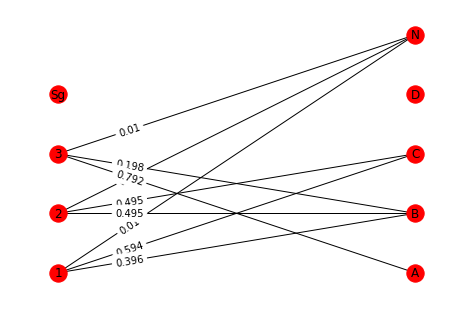

In [184]:
m = list(n for n,d in G.nodes(data=True) if d['bipartite']==0)
n = list(n for n,d in G.nodes(data=True) if d['bipartite']==1)
n.remove('N')
n.append('N')
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(m) ) 
pos.update( (n, (2, i)) for i, n in enumerate(n) ) 
nx.draw(G, pos=pos, with_labels = True)
labels = nx.get_edge_attributes(G,'weight')
res = nx.draw_networkx_edge_labels(G,pos,label_pos = 0.8,edge_labels=labels)

In [185]:
weights = defaultdict(int,labels)
M = len(m)
N = len(n)
A = []
I = []
b = []
def GenerateRP(S):
    R = np.zeros((N-1,M))
    P =np.zeros((M,N-1))
    val = 0.5
    newEdges = list(zip(repeat('Sg'),S,repeat(val)))
    G.add_weighted_edges_from(newEdges)
    for i,item in enumerate(m):
        for j,tag in enumerate(n):
            if(tag!='N'):
                R[j,i]=1/G.degree(tag) if G.has_edge(tag,item) else 0
                P[i,j] = weights[(item,tag)]
    G.remove_edges_from(newEdges)
    r=R[:,-1:]
    return R,r,P
def Generate(S):
    R,r,P= GenerateRP(S)
    A= np.zeros((np.shape(R)[0]+np.shape(P)[0],np.shape(R)[1]+np.shape(P)[1]))
    A[np.shape(R)[0]:,:np.shape(P)[1]] = P
    A[:np.shape(R)[0],np.shape(P)[1]:] = R
    B = np.zeros(np.shape(A))
    B[:np.shape(r)[0],-np.shape(r)[1]:] = r
    B[np.shape(r)[0]:,:-np.shape(r)[1]] = eps
    b = B[:,-1:]
    return A,b,R,r,P

In [186]:
def value(nS):
    R,r,P = GenerateRP(nS)
    # c =(I - R(nS)P)\r(nS))
    c= np.dot(np.linalg.inv(np.identity(M)-np.dot(R,P)),r)
    return np.sum(c)
def SimpleGreedyTagOpt(k):
    S = []
    for i in range(k):
        res = []
        zs = [z for z in n if not z in S and z!='N']
        for z in zs:
            c = value(list(z)+S)
            #print("With:",z,' c=',c)
            res.append(c)
        S.append(zs[np.argmax(res)])
    return S
SimpleGreedyTagOpt(3)

['A', 'D', 'C']